## MiniLab Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Data preparation: Adjustments](#DataPrep)
    2. [Data preparation for Support Vector Machine](#SVGDataSet)

[Feature Selection](#FeatureSelection)
  * [VIF Feature Removal](#VIF)
  * [Logistic Regression](#LogsticRegression)
    * [Feature Importance](#FI)
	* [Logistic Refit](#Refit)
	* [GridSearch Results](#GridSearch)


# Mel Schwan, Stuart Miller, Justin Howard, Paul Adams
# Mini Lab: Logistic Regression and Support Vector Machine

In MiniLab2 we will perform predictive analysis (classification) upon a data set we cleaned in the Lab1. We will model the dataset using methods we have discussed in class. Logistic regression and support vector machines will be used in making conclusions from the analysis. The following phases of CRISP will be documented it the notebook.


<img src="./crisps-dm-minilab.png" style="width:550px;height:450px"/>


# 1. Stage Three - Data Preparation (Q1)   <a class="anchor" id="DataPreparation"></a>

To produce useful descriptive and predictive models, our team found it necessary to systematically re-examine assumptions we previously held. During our modeling process, we built and evaluated models, used these evaluations to introduce changes to the dataset and applied treatments to the data, and progressively move toward more useful models. 
The product of the Data Preparation and Modeling Phases produced valuable insights into our dataset:
1. We discovered unfounded bias against features we previously deemed less useful
2. We found it necessary to research and experiment with a variety of sampling techniques

## 1.1 Data preparation: Adjustments (Q1A)<a class="anchor" id="DataPrep"></a>

The dataset we are analyzing consists of a mixture of attributes scraped from loan applications and credit bureaus. Overall, the dataset is sparsely populated due to Home Credit's focus on applicants with little to no credit history. 

**Assumption Changes:**
1. The EXTERNAL_SOURCE_1 and OWN_CAR_AGE features contribute significantly to a predictive model and were re-introduced to the dataset.
2. The CNT_FAM_MEMBERS, CNT_CHILDREN, CREDIT_ACTIVE, LOAN_COUNT were more valuable as binned categorical features than as high-cardinality integer counts.
3. Using under-sampling techniques produced better results than over-sampling techniques did.



In [41]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# others
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions
from sklearn.metrics import roc_curve, auc

# custom functions
from cleaning import read_clean_data, impute_data
from tables import classification_report

# set random seed
random_state = 1
np.random.seed(random_state)

In [106]:
from sklearn.base import BaseEstimator, TransformerMixin


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# loading data that was preprocessed using the custom read_clean_data() function, 
# merged with the previously engineered newFeatures from Lab 1 

data = pd.read_csv('data.csv', na_values = 'XNA')

**Reducing High Cardinality Features**

In [3]:
data.CNT_FAM_MEMBERS.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])

The dataset contains features, such as the number of children an applicant has, where the number of unique values is relatively high. Still, the percentage of total makeup is almost imperceptible. The distributions of these high cardinality variables are heavily skewed. We tried to address this issue by reducing the number of numeric categories to get a more accurate interpretation of their impact on the target variable.

In [4]:
#recoding high cardinality features

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'
data['cnt_child'] = data.CNT_CHILDREN.apply(cnt_child).astype('category')

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'
data['cnt_family'] = data.CNT_FAM_MEMBERS.apply(cnt_family).astype('category')

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'
data['credit_active'] = data.CREDIT_ACTIVE.apply(credit_active).astype('category')

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'

data['loan_cnt'] = data.LOAN_COUNT.apply(loan_count).astype('category')

In [5]:
data.shape

(307511, 94)

### 1.1.1 Second Principal Component Analysis

Our feature selection decisions prompted a review of the Principal Components to see if a more significant separation between the classes is evident. We dropped variables that seemed the least useful for this type of analysis. Next, we on-hot encoded to eliminate the duplication of categorical features that were already binary indicators.

In [6]:
# dropping variables that were deemed the least useful for analysis
new_df = data.copy().drop(['TARGET', 'SK_ID_CURR', 'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV', 'LOAN_COUNT',
                          'CREDIT_ACTIVE'], axis = 1)
# one-hot encoding
# adding drop_first = True eliminates the duplication of categorical features that are already binary indicators
new_df = pd.get_dummies(new_df, drop_first = True)
pd.options.display.max_columns = 400
new_df.describe()

,Unnamed: 0,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMPLOYED,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,PERCENT_EMPLOYED_TO_AGE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_Y,FLAG_EMP_PHONE_Y,FLAG_WORK_PHONE_Y,FLAG_CONT_MOBILE_Y,FLAG_PHONE_Y,FLAG_EMAIL_Y,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_None,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,REG_REGION_NOT_LIVE_REGION_Y,REG_REGION_NOT_WORK_REGION_Y,LIVE_REGION_NOT_WORK_REGION_Y,REG_CITY_NOT_LIVE_CITY_Y,REG_CITY_NOT_WORK_CITY_Y,LIVE_CITY_NOT_WORK_CITY_Y,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_None,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,

In [7]:
sc = StandardScaler()
sc.fit(new_df)
X_train_std = sc.transform(new_df) 
X_train_std.shape

(307511, 193)

After dropping the least useful variables and preforming a one-hot encoding, the resulting data set had an increase in the features from 92 to 192.

In [8]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nTop Ten Eigenvalues \n%s' % eigen_vals[0:9])


Top Ten Eigenvalues 
[8.05794362 3.69872521 3.37219416 3.07843586 2.74807889 2.50659303
 2.4647468  2.35817863 2.17330637]


In [9]:
# calculating the total var explained and cumulative variance
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse =True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)
len(cum_var_exp)
print("Variance Explained length: " + str(len(var_exp)), "\nCumulative Variance Explained length : " + str(len(cum_var_exp)))

Variance Explained length: 193 
Cumulative Variance Explained length : 193


ValueError: shape mismatch: objects cannot be broadcast to a single shape

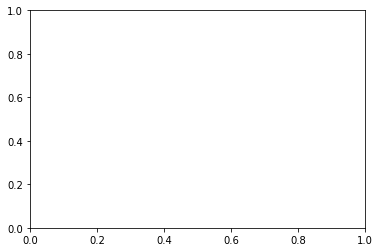

In [10]:
plt.bar(range(1,193), var_exp, alpha = .5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(1,193), cum_var_exp, where = 'mid', label = 'Cumulative Variance Explained')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Componenet Index')
plt.legend(loc='best')
plt.show()

**Significant Findings**

To capture at least 80% of the variability in the dataset, we must include around 125 principal components. While this is a large number of features, our previous dataset contained 302 features. Our efforts to reduce the cardinality of several features were effective. 

We will pair the eigenvectors with their corresponding eigenvalues and project them onto a 2-dimensional subspace and observe the results.

In [ ]:
# making a listof (eigenvalues, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
"""eigen_pairs[0] is equivalent to the single eigenvalue for PC1 and the eigenvector that represents the 190 features of the data"""
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

#collecting the two eigenvectors that correspond to the two largest eigenvalues

W = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))

# printing the first 5 pairs
print('Matrix W: \n', W[:5])

We can use this matrix to transform the training set into new features and plot them. First, we will observe the first 2 Principal Components with a logistic regression-based decision boundary to view the discriminatory ability of a logistic model using the Principal Components.

In [ ]:
#transforming training data
X_train_pca = X_train_std.dot(W)

# identifying labels
y_train = data.TARGET

#initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components =2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
#fitting the logitistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

**Significant Findings**

From this plot, we can see that class separation is very poor and non-linear. We have two centroids where each has only a slight concentric-ellipse type of separation between the two classes. The decision boundary drawn by a logistic model is clearly unable to use the first two principal components to discriminate between defaults and non-defaulted loans.


We can also attempt to view the value of the third principal component to see if there is good separation when we add a third dimension.

In [ ]:
# getting three principal components
W3 = np.hstack((W,eigen_pairs[2][1][:,np.newaxis]))
W3.shape

In [ ]:
#transforming training data
X_train_pca3 = X_train_std.dot(W3)
X_train_pca3.shape

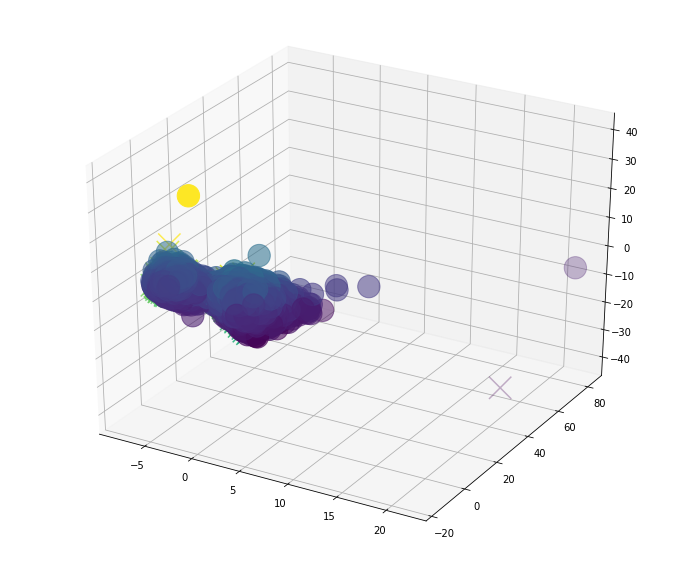

In [14]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')


colors = ['r','g']
markers = ['o', 'x']

# for each index and class in:
for idx, cl in enumerate(np.unique(y_train)):
    ax.scatter3D(X_train_pca3[y_train == cl, 0],
                X_train_pca3[y_train == cl, 1],
                X_train_pca3[y_train == cl, 2],
                label = cl,
                s=500,
                c = X_train_pca3[y_train == cl, 2],
                cmap = 'viridis',
                marker = markers[idx])

**Significant Findings**

A three dimensional plot of the data does provide some insights. Defaults can be separated along the third dimension, as indicated by the defaults being clustered in the blue region and the non-defaults being clustered in the green/yellow regions of the third Principal Component.

1. The overlap between the classes is so signficant even in the third dimension, that the boundary line is not clear.

2. We will apply sampling strategies that will clarify the class boundaries.

 ## 1.2 Data Preparation (Q1b) <a class="anchor" id="Dataprep"></a>

We combined multiple stratification and sampling techniques to the data before training the model:

1. Imputations are calculated based on the training set and applied to the test set.
2. A stratefied training/test set by `TARGET` : to guarantee similar distributions
3. Random-undersampling by the engineered categorical `CAT_INCOME` : clarify the boundaries between income strata
4. Tomek Link under-sampling by `TARGET` : clarify the boundaries between `TARGET` classes

### 1.2.1 Stratified Sampling by Incomes

Our first step is to separate the `AMT_INCOME_TOTAL` feature and create a new feature by dividing incomes into quantiles.

In [11]:
#create quantiles with simple category names based on the quantile ranges

income_labels = ['$25,659 - $112,500', '$112,500 - $147,150',
                 '$147,150 - $202,500','$202,500 - $117,000,000']

CAT_INCOME = pd.qcut(data['AMT_INCOME_TOTAL'], q = 4,
                    labels = income_labels)

CAT_INCOME.values

[$147,150 - $202,500, $202,500 - $117,000,000, $25,659 - $112,500, $112,500 - $147,150, $112,500 - $147,150, ..., $147,150 - $202,500, $25,659 - $112,500, $147,150 - $202,500, $147,150 - $202,500, $147,150 - $202,500]
Length: 307511
Categories (4, object): [$25,659 - $112,500 < $112,500 - $147,150 < $147,150 - $202,500 < $202,500 - $117,000,000]

In [12]:
# simplifying category names
data['CAT_INCOME'] = CAT_INCOME.astype('category')
#use the get_dummies function to quickly find the percentage of the dataset that each quantile makes up
pd.get_dummies(data.CAT_INCOME).describe()

,"$25,659 - $112,500","$112,500 - $147,150","$147,150 - $202,500","$202,500 - $117,000,000"
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.327071,0.172943,0.267350,0.232636
std,0.469144,0.378199,0.442577,0.422513
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


**Splitting the Data**

Now that we have the `CAT_INCOME` feature, we can gather the features we want to include in our model and form strata. 

Before we perform any sampling techniques, we must split our data into training and test sets. Our training set will consist of approximately 80% of the data, while the test set will be set aside for validation.
Imputation is only calculated based on the training data.

In [13]:
# read in the data without imputions that are distribution dependent
data = read_clean_data(preimpute = False)

In [14]:
# forming new dataset with target included. We will still drop features that we already decided were not useful.
strat_inc = data.copy().drop(labels = ['SK_ID_CURR','AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV'], axis = 1)
#print(list(strat_inc.columns))

Before we create our income strata, we will stratefy the training and test data by the `TARGET` variable to assure that class labels in both the training and test sets a distributed the same way.

In [15]:
# stratify the training and test sets by the target first
# must keep TARGET in the training sets at this point to under sample by income
y = strat_inc.TARGET
X = strat_inc
# setting random_state
random_state = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state, stratify = y)
print('y_train count: ' + str(y_train.count()) + '\ny_test count: ' + str(y_test.count()) +
      '\nTotal: ' + str(y_train.count() + y_test.count()))

y_train count: 246008
y_test count: 61503
Total: 307511


**Imputation**

The function `impute_data` calculates imputations values for the following values and applies these values to test set.
For categorical variables imputation of the mode was used.
For continuous variables imputation of the median was used.

| Variable | Imputation Method |
|----------|-------------------|
| CODE_GENDER | Mode |
| NAME_TYPE_SUITE | Mode |
| OBS_30_CNT_SOCIAL_CIRCLE | Median |
| DEF_30_CNT_SOCIAL_CIRCLE | Median |
| OBS_60_CNT_SOCIAL_CIRCLE | Median |
| DEF_60_CNT_SOCIAL_CIRCLE | Median |
| AMT_ANNUITY |  Median |
| ANNUITY_INCOME_RATIO |  Median |
| DAYS_LAST_PHONE_CHANGE |  Median |


In [16]:
X_train, X_test = impute_data(X_train, X_test)

# apply income splits
X_train.CAT_INCOME = pd.qcut(X_train['AMT_INCOME_TOTAL'], q = 4,
                             labels = income_labels)
X_test.CAT_INCOME = pd.qcut(X_test['AMT_INCOME_TOTAL'], q = 4,
                             labels = income_labels)

In [17]:
# combine the imputated test and train for analysis of the SVM
data_imputed = pd.concat([X_train, X_test])

**Creating Income Strata**

We will now take the training set and under-sample all the income categories except the majority category so that it is represented better.

In [18]:
# We are deciding to under sample all strata except the majority class
rus = RandomUnderSampler(random_state = random_state,
                         sampling_strategy = 'not majority')

# we are undersampling based on strata defined by the CAT_INCOME variable
y_inc = X_train.CAT_INCOME
X_rus, y_rus = rus.fit_resample(X_train,y_inc)
X_rus.shape

(207915, 75)

Now that we have applied an under-sampling strategy to make the majority income class more easily seperable, we can now under-sample by the `TARGET` feature to further clarify the boundary.

In [19]:
# preparing training data 

#removing TARGET from training data
y_train = X_rus.pop('TARGET')
#getting dummy variables
X_train = pd.get_dummies(X_rus, drop_first = True)


# preparing test data for evaluation
y_test = X_test.pop('TARGET')
# create SVM test set with out dummies
X_test_svm = X_test.copy()
# create test set with dummies
X_test = pd.get_dummies(X_test, drop_first = True)

# define a function to make empty features for missing features
cols = list(X_train.columns)
def add_missing_dummies(d, cols):
    missing_cols = set(cols) - set(d.columns)
    for c in missing_cols:
        d[c] = 0
add_missing_dummies(X_test, cols)

print('Shape of Training set: ' + str(X_train.shape) + '\nShape of Test set: ' + str(X_test.shape))

Shape of Training set: (207915, 176)
Shape of Test set: (61503, 176)


We will take the X_rus training data, which is randomly under-sampled by income and under-sample it once more according to the TomekLinks to make the boundary between the classes more evident.

In [23]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X_train, y_train)

**Resampling the Training Data**

Initially, the models were trained against training data that contained mostly non-defaulting instances. However, the model's performance on this initial training data was inferior, generally failing to classify any defaulting instances. The remedy to this issue was to resample the training data to balance the number of non-defaulting and defaulting instances. All the defaulting instances were retained, but the non-defaulting instances were randomly downsampled to match the number of non-defaulting instances. Resampled training data improved the performance of the models substantially when validated on the test data. 

The test data was **not** resampled.

Additionally, the categroical variables were label encoded, rather than one-hot encoded.

In [20]:
#removing TARGET from training data
y_train_SVM = y_train.copy()
#getting dummy variables
X_train_SVM = X_rus.copy()

In [22]:
# need to down sample to deal with training computation time
# training on whole set takes about 12hr
# use about 20% of the training data
downsampled = X_train_SVM.copy()
downsampled['TARGET'] = y_train_SVM

In [23]:
cols_encode = ['ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START','OCCUPATION_TYPE',
              'NAME_FAMILY_STATUS','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE',
              'NAME_HOUSING_TYPE','NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']

le = LabelEncoder()
for col in cols_encode:
    downsampled[col] = le.fit_transform(downsampled[col])
    X_test_svm[col] = le.transform(X_test_svm[col])

downsampled = downsampled.drop(labels = ['AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)
X_test_svm = X_test_svm.drop(labels = ['AMT_REQ_CREDIT_BUREAU_HOUR',
                                         'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                                         'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',
                                         'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE'], axis = 1)


In [24]:
defaults = downsampled.query('TARGET == 1')
nominal = downsampled.query('TARGET == 0').sample(n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int),
                                                  random_state = random_state)
# join dataframes and shuffle
downsampled = pd.concat([defaults, nominal]).sample(frac = 1, 
                                                    random_state = random_state)

X_train_svm = downsampled.drop(labels = ['TARGET'], axis = 1)
y_train_svm = downsampled.TARGET

# transform the data
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

In [115]:
X_train_svm_as_df = pd.DataFrame(X_train_svm, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)

In [ ]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0):
        """Iteratively calculate VIF and drop features with highest VIF until
        all VIF values are below the threshold value (`thresh`).
        
        Adapted from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
        """
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

# Feature Selection <a class="anchor" id="FeatureSelection"></a>

Feature selection was performed by removing features with high variance inflation factor (VIF) and ranking features by feature importance  with an ensemble of models (regularized logistic regression).



## VIF Feature Removal <a class="anchor" id="VIF"></a>

High VIF is an [indication of multicollinearity](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).
Typically, limiting VIF of individual features to 5 is considered reasonable.
For removal by VIF, features with high VIF were removed iteratively until the VIF for all remain features was less than 5.
The removed features are printed by the code below.

In [166]:
transformer = ReduceVIF()
X = transformer.fit_transform(X_train_svm_as_df)

ReduceVIF fit
ReduceVIF transform
Dropping FLAG_EMP_PHONE with vif=inf
Dropping OBS_60_CNT_SOCIAL_CIRCLE with vif=305.3946955343683
Dropping DAYS_EMPLOYED with vif=26.56876041129738
Dropping CREDIT_INCOME_RATIO with vif=12.804099800794145
Dropping FLAG_DOCUMENT_3 with vif=12.364427566035257
Dropping REGION_RATING_CLIENT with vif=11.32963331226173
Dropping REG_REGION_NOT_WORK_REGION with vif=8.868417498179573
Dropping REG_CITY_NOT_WORK_CITY with vif=6.577035347074841


## Logistic Regression <a class="anchor" id="LogsticRegression"></a>

Each type of regularized logistic regression (L1, L2, ElasticNet) was grid search for the bast hyperparameters.
Then the regularized logistic regression models were fit with the hyperparameters selected by [grid search]().
After the fits, features where ranked by the mean absolute importance from the model fits ([see table](#FI)).

**Note**: ElasticNet was not refit because the grid search or elastic net selected 0 for the regularization mixing parameter,
  which is just L1 regularization.

In [167]:
logistic_l1 = LogisticRegression(C = 0.046,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 random_state = random_state)
logistic_l1.fit(X, y_train_svm);

In [174]:
coefs = logistic_l1.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l1 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l1['Abs Weight'] = np.abs(final_df_logistic_l1['Logistic Weight'])
final_df_logistic_l1.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l1.to_string(index=False))

In [169]:
logistic_l2 = LogisticRegression(C = 0.001, 
                                 penalty = 'l2',
                                 solver = 'lbfgs', 
                                 random_state = random_state)
logistic_l2.fit(X, y_train_svm);

In [175]:
coefs = logistic_l2.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l2 = df_new_coeffs.sort_values('Logistic Weight')
#final_head = final_df_logistic.head(10)
#final_tail = final_df_logistic.tail(10)
#final_weights = pd.concat([final_head, final_tail], axis=0)
#final_weights['Abs Weight'] = np.abs(final_weights['Logistic Weight'])
#final_weights.sort_values('Abs Weight', ascending=False)
final_df_logistic_l2['Abs Weight'] = np.abs(final_df_logistic_l2['Logistic Weight'])
final_df_logistic_l2.sort_values('Abs Weight', ascending=False, inplace = True)
#print(final_df_logistic_l2.to_string(index=False))

In [176]:
# prevent risk of object corruption
l2 = final_df_logistic_l2.sort_values('Feature').copy().add_suffix('_l2')
l1 = final_df_logistic_l1.sort_values('Feature').copy().add_suffix('_l1')

### Feature Importance <a class="anchor" id="FI"></a>

The importances were combined for each model and ranked by the mean absolute importance (logstic weight).
The weights for each model were also included. 
The difference and percent difference between the weights for each model is also shown.

The difference in feature weight between the two models is not substantial in the first 30 features.
There are only a feature features with substantial differences in weights, such as sign changes.
All of these features have low importances.

In [177]:
combined = pd.concat([l1, l2], keys=['Feature_l1', 'Feature_l2'], axis = 1)
combined['Average Weight'] = (combined['Feature_l1']['Abs Weight_l1'] 
                              + combined['Feature_l2']['Abs Weight_l2']) / 2
average_weights = pd.DataFrame()
average_weights['Mean_Abs_Weight'] = combined['Average Weight']
average_weights['Feature'] = combined['Feature_l1']['Feature_l1']
average_weights['l1_Weight'] = combined['Feature_l1']['Logistic Weight_l1']
average_weights['l2_Weight'] = combined['Feature_l2']['Logistic Weight_l2']
average_weights['Importance_Difference'] = average_weights['l1_Weight'] - average_weights['l2_Weight']
average_weights['Importance_Difference_%'] = (average_weights['Importance_Difference'] 
                                              / average_weights['Mean_Abs_Weight'] 
                                              * 100)
average_weights = average_weights.sort_values('Mean_Abs_Weight', ascending = False).reset_index(drop = True)
average_weights

,Mean_Abs_Weight,Feature,l1_Weight,l2_Weight,Importance_Difference,Importance_Difference_%
0,0.410622,EXT_SOURCE_2,-0.437585,-0.383660,-0.053925,-13.132489
1,0.326820,EXT_SOURCE_3,-0.345469,-0.308171,-0.037298,-11.412299
2,0.144593,PERCENT_EMPLOYED_TO_AGE,-0.155243,-0.133943,-0.021301,-14.731463
3,0.136021,CODE_GENDER,-0.143879,-0.128162,-0.015717,-11.554760
4,0.135256,EXT_SOURCE_1,-0.139501,-0.131011,-0.008490,-6.277356
5,0.125328,NAME_CONTRACT_TYPE,-0.132077,-0.118579,-0.013498,-10.769823
6,0.119400,NAME_EDUCATION_TYPE,0.123910,0.114890,0.009020,7.554352
7,0.107675,DAYS_BIRTH,-0.108837,-0.106512,-0.002325,-2.159060
8,0.106952,EMPLOYED,0.120548,0.093356,0.027192,25.424890
9,0.104847,FLAG_OWN_CAR,-0.116278,-0.093417,-0.022861,-21.804376


### Refit with Important Features <a class="anchor" id="Refit"></a>

The L2 regularized logistic model was refit with the 15 most important features (shown below).
The produces 64.99% recall and 15.12% precision, which is an improvement over the baseline logistic model (Recall: 63.06%, Precision: 14.36%).

In [190]:
average_weights.iloc[0:15].Feature

0                    EXT_SOURCE_2
1                    EXT_SOURCE_3
2         PERCENT_EMPLOYED_TO_AGE
3                     CODE_GENDER
4                    EXT_SOURCE_1
5              NAME_CONTRACT_TYPE
6             NAME_EDUCATION_TYPE
7                      DAYS_BIRTH
8                        EMPLOYED
9                    FLAG_OWN_CAR
10    REGION_RATING_CLIENT_W_CITY
11       DEF_30_CNT_SOCIAL_CIRCLE
12                DAYS_ID_PUBLISH
13                FLAG_WORK_PHONE
14         REG_CITY_NOT_LIVE_CITY
Name: Feature, dtype: object

In [188]:
l = LogisticRegression(C = 0.001, 
                         penalty = 'l2',
                         solver = 'lbfgs', 
                         random_state = random_state)
l.fit(X[average_weights.iloc[0:15].Feature],y_train_svm)
X_test_asdf = pd.DataFrame(X_test_svm, columns=downsampled.drop(labels = ['TARGET'], axis = 1).columns)
preds = l.predict(X_test_asdf[average_weights.iloc[0:15].Feature])
classification_report(y_test, preds)

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38423  18115  56538
1           1738   3227   4965
All        40161  21342  61503

Accuracy: 67.72% 
Precision: 15.12% 
Recall: 64.99%


**ROC Curve**

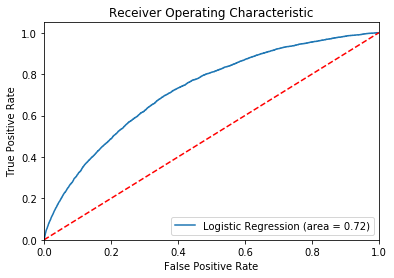

In [192]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, l.predict_proba(X_test_asdf[average_weights.iloc[0:15].Feature])[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression Parameter Grid Search <a class="anchor" id="GridSearch"></a>

Each type of regularized logistic regression was grid search for the best hyperparameters before fitting the model for estimating feature importances.

* L2 Regulaization
* L1 Regulaization
* Elastic Net Regulaization

### L2 Regulaization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ for L2 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

In [ ]:
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'newton-cg',
                     'lbfgs',
                     'sag',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l2', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
# Fit on data
#best_clf = clf.fit(X_train_svm, y_train_svm)

### l1 Regularization

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-10, 10) with 100 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘liblinear’ and ‘saga’ for L1 regularization
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 100 steps

```python
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':[
                     'liblinear',
                     'saga'
                 ],
        'C':np.logspace(-4, 4, 10)
    }]

model = LogisticRegression(penalty = 'l1', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
```

```
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.046415888336127774, 'solver': 'saga'}

Grid scores on development set:

0.250 (+/-0.000) for {'C': 0.0001, 'solver': 'liblinear'}
0.250 (+/-0.000) for {'C': 0.0001, 'solver': 'saga'}
0.638 (+/-0.009) for {'C': 0.000774263682681127, 'solver': 'liblinear'}
0.638 (+/-0.009) for {'C': 0.000774263682681127, 'solver': 'saga'}
0.661 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'liblinear'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'solver': 'saga'}
0.663 (+/-0.006) for {'C': 0.3593813663804626, 'solver': 'liblinear'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'solver': 'saga'}
0.662 (+/-0.007) for {'C': 2.782559402207126, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 21.54434690031882, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 166.81005372000558, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 1291.5496650148827, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 10000.0, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 10000.0, 'solver': 'saga'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38460  18078  56538
1           1701   3264   4965
All        40161  21342  61503

Accuracy: 67.84% 
Precision: 15.29% 
Recall: 65.74%
None

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.046415888336127774, 'solver': 'saga'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.0001, 'solver': 'liblinear'}
0.500 (+/-0.000) for {'C': 0.0001, 'solver': 'saga'}
0.637 (+/-0.009) for {'C': 0.000774263682681127, 'solver': 'liblinear'}
0.637 (+/-0.009) for {'C': 0.000774263682681127, 'solver': 'saga'}
0.661 (+/-0.007) for {'C': 0.005994842503189409, 'solver': 'liblinear'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'solver': 'liblinear'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'solver': 'saga'}
0.662 (+/-0.007) for {'C': 2.782559402207126, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 21.54434690031882, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 166.81005372000558, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 1291.5496650148827, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 10000.0, 'solver': 'liblinear'}
0.663 (+/-0.007) for {'C': 10000.0, 'solver': 'saga'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38460  18078  56538
1           1701   3264   4965
All        40161  21342  61503

Accuracy: 67.84% 
Precision: 15.29% 
Recall: 65.74%
None
```

### Elastic Net

#### Grid Search Parameters

* `C`
  * Inverse of the regulaization strength 
  * (-4, 4) with 10 steps in a log space
* `solver`
  * Optimization algorithm
  * ‘saga’ for elastic-net
* `l1_ratio`
  * The elastic net mixing ratio
  * (0, 1) with 10 steps

```python
scores = ['precision', 'recall']

# Create tuned parameters.
tuned_parameters = [
    {
        'solver':['saga'],
        'C':np.logspace(-4, 4, 10),
        'l1_ratio':np.linspace(0, 1, 10)
    }]

model = LogisticRegression(penalty = 'elasticnet', random_state = random_state)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        model,
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(X_train_svm, y_train_svm)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_svm)
    print(classification_report(y_true, y_pred))
    print()
    
```

```
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.000774263682681127, 'l1_ratio': 0.0, 'solver': 'saga'}

Grid scores on development set:

0.660 (+/-0.008) for {'C': 0.0001, 'l1_ratio': 0.0, 'solver': 'saga'}
0.645 (+/-0.009) for {'C': 0.0001, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.634 (+/-0.007) for {'C': 0.0001, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.614 (+/-0.012) for {'C': 0.0001, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.250 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 1.0, 'solver': 'saga'}
0.664 (+/-0.007) for {'C': 0.000774263682681127, 'l1_ratio': 0.0, 'solver': 'saga'}
0.662 (+/-0.008) for {'C': 0.000774263682681127, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.000774263682681127, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.657 (+/-0.006) for {'C': 0.000774263682681127, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.654 (+/-0.008) for {'C': 0.000774263682681127, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.649 (+/-0.008) for {'C': 0.000774263682681127, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.646 (+/-0.010) for {'C': 0.000774263682681127, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.643 (+/-0.011) for {'C': 0.000774263682681127, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.640 (+/-0.007) for {'C': 0.000774263682681127, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.638 (+/-0.009) for {'C': 0.000774263682681127, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.005994842503189409, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.005994842503189409, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.662 (+/-0.005) for {'C': 0.005994842503189409, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 1.0, 'solver': 'saga'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38448  18090  56538
1           1700   3265   4965
All        40148  21355  61503

Accuracy: 67.82% 
Precision: 15.29% 
Recall: 65.76%
None

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.000774263682681127, 'l1_ratio': 0.0, 'solver': 'saga'}

Grid scores on development set:

0.660 (+/-0.008) for {'C': 0.0001, 'l1_ratio': 0.0, 'solver': 'saga'}
0.645 (+/-0.009) for {'C': 0.0001, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.633 (+/-0.007) for {'C': 0.0001, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.611 (+/-0.011) for {'C': 0.0001, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.500 (+/-0.000) for {'C': 0.0001, 'l1_ratio': 1.0, 'solver': 'saga'}
0.664 (+/-0.007) for {'C': 0.000774263682681127, 'l1_ratio': 0.0, 'solver': 'saga'}
0.662 (+/-0.008) for {'C': 0.000774263682681127, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.000774263682681127, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.657 (+/-0.006) for {'C': 0.000774263682681127, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.653 (+/-0.008) for {'C': 0.000774263682681127, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.649 (+/-0.007) for {'C': 0.000774263682681127, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.646 (+/-0.010) for {'C': 0.000774263682681127, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.642 (+/-0.011) for {'C': 0.000774263682681127, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.640 (+/-0.007) for {'C': 0.000774263682681127, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.637 (+/-0.009) for {'C': 0.000774263682681127, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.005994842503189409, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.005994842503189409, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.662 (+/-0.005) for {'C': 0.005994842503189409, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.661 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.662 (+/-0.006) for {'C': 0.005994842503189409, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.046415888336127774, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.046415888336127774, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 0.3593813663804626, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.008) for {'C': 0.3593813663804626, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 2.782559402207126, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 21.54434690031882, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 166.81005372000558, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 1291.5496650148827, 'l1_ratio': 1.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.0, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.1111111111111111, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.2222222222222222, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.3333333333333333, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.4444444444444444, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.5555555555555556, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.6666666666666666, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.7777777777777777, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 0.8888888888888888, 'solver': 'saga'}
0.663 (+/-0.007) for {'C': 10000.0, 'l1_ratio': 1.0, 'solver': 'saga'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Classification Report

Confusion Matrix
Predicted      0      1    All
True                          
0          38448  18090  56538
1           1700   3265   4965
All        40148  21355  61503

Accuracy: 67.82% 
Precision: 15.29% 
Recall: 65.76%
None
```